<a href="https://colab.research.google.com/github/JackRio/Style-Transfer/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Style Transfer 
Paper: [Neural-Style Algorithm](https://arxiv.org/abs/1508.06576)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
image_size = 512 if torch.cuda.is_available() else 128

In [4]:
loader = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    
    image = loader(image).unsqueeze(0) # adding batch dimension for matching network input dimensions
        
    return image.to(device, torch.float)

style_image = image_loader('./images/picasso.jpg')
content_image = image_loader("./images/dancing.jpg")

assert style_image.size() == content_image.size(), \
    "Style and Content imagae style should be of the same size."

In [6]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    

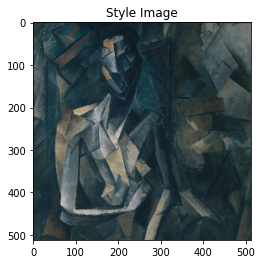

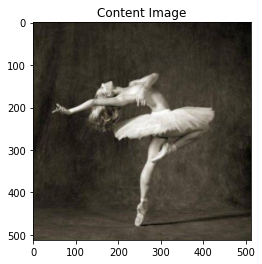

In [7]:
plt.figure()
imshow(style_image, "Style Image")

plt.figure()
imshow(content_image, "Content Image")


**Content Loss**
    
The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps $F_{XL}$ of a layer **L** in a network processing input **X** and returns the weighted content distance $w_{CL}$ . $D^L_C$ $(X,C)$ between the image X and the content image C. The feature maps of the content image( $F_{CL}$ ) must be known by the function in order to calculate the content distance. We implement this function as a torch module with a constructor that takes $F_{CL}$ as an input. The distance $∥F_{XL}−F_{CL}∥_2$ is the mean square error between the two sets of feature maps, and can be computed using ```nn.MSELoss```.

We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers  and because of auto grad, all the gradients will be computed. Now, in order to make the content loss layer transparent we must define a ```forward``` method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Style Loss**

The style loss module is implemented similarly to the content loss module. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps $F_{XL}$ of a layer L. $F_{xL}$ is reshaped to form $F^._{XL}$, a $K * N$ matrix, where K is the number of feature maps at layer L and N is the length of any vectorized feature map $F^k_{XL}$. For example, the first line of $F^._{XL}$ corresponds to the first vectorized feature map $F^1_{XL}$.

Finally, the gram matrix must be normalized by dividing each element by the total number of elements in the matrix. This normalization is to counteract the fact that $F^._{XL}$ matrices with a large **N** dimension yield larger values in the Gram matrix. These larger values will cause the first layers (before pooling layers) to have a larger impact during the gradient descent. Style features tend to be in the deeper layers of the network so this normalization step is crucial.

In [9]:
def gram_matrix(input):
    a,b,c,d = input.size()
    # a batch size
    # b number of feature maps
    # (c,d) Dimensions of f map (N = c*d)
    
    features = input.view(a*b, c*d)
    
    G = torch.mm(features, features.t())
    
    # Normalize the value of the Gram Matrix
    return G.div(a * b * c *d)

In [16]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

**Model Import** 

    Going to use the 19 layer VGG network like the one used in the paper

In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\sanvy/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


In [19]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normali zation_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [56]:
class Normalization(nn.Module):
    """
        Normalization class for Style Transfer
    """
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [57]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [58]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [64]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    # normalization module
    normalization = Normalization(mean = normalization_mean, std = normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name,layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

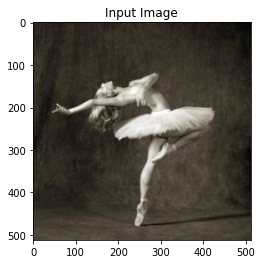

In [83]:
input_img = content_image.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_image.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

**Gradient Descent**

    We will use L-BFGS algorithm to run our gradient descent. 

In [78]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [79]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


C:\Users\sanvy\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sanvy\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [50]:
Style Loss : 4.053813 Content Loss: 4.095834

run [100]:
Style Loss : 1.123595 Content Loss: 3.018054

run [150]:
Style Loss : 0.708979 Content Loss: 2.650737

run [200]:
Style Loss : 0.473218 Content Loss: 2.489698

run [250]:
Style Loss : 0.342445 Content Loss: 2.400674

run [300]:
Style Loss : 0.262210 Content Loss: 2.348062



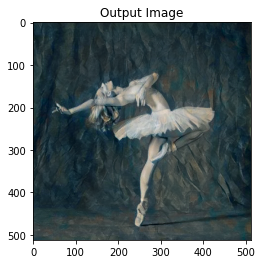

In [84]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
